In [64]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import joblib
import shap
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score,  make_scorer, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
weight_decay = 1e-4
batch_size = 64
num_epochs = 75
num_runs = 3
max_patience = 13

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

Using device: cuda


In [65]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, y=None, threshold=0.7):

    df_copy = df.copy()

    if y is not None and y.name in df_copy.columns:
        df_copy = df_copy.drop(columns=[y.name])
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in cat_cols:
        df_copy[col] = df_copy[col].astype("category").cat.codes
    
    print(f"Dataset shape: {df_copy.shape}")
    print(f"Total rows: {len(df_copy)}")
    print(f"Total duplicate rows: {df_copy.duplicated().sum()}")

    summary = pd.DataFrame({
        "dtype": df_copy.dtypes,
        "non_null": df_copy.notna().sum(),
        "missing": df_copy.isna().sum(),
        "missing_%": (df_copy.isna().mean() * 100).round(2),
        "unique": df_copy.nunique()
    })

    numeric_cols = df_copy.select_dtypes(include="number").columns
    feature_cols = df_copy.columns.tolist()
    desc = df_copy[numeric_cols].describe().T
    desc["skew"] = df_copy[numeric_cols].skew()
    summary = summary.join(desc[["mean", "std", "min", "25%", "50%", "75%", "max", "skew"]])

    if y is not None:
        df_copy['target'] = y
        summary["corr_with_target"] =  df_copy.corr()['target'].drop('target')

    corr_matrix = df_copy.corr(numeric_only=True)
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
    
    high_corr = corr_pairs[abs(corr_pairs) > threshold]
    
    corr_map = {}
    for (f1, f2), val in high_corr.items():
        corr_map.setdefault(f1, []).append(f"{f2} ({val:.2f})")
        corr_map.setdefault(f2, []).append(f"{f1} ({val:.2f})")
    
    summary["high_corr_flag"] = summary.index.map(lambda col: col in corr_map)
    summary["high_corr_with"] = summary.index.map(
        lambda col: ", ".join(corr_map[col]) if col in corr_map else ""
    )

    return summary.sort_values("missing_%", ascending=False)

def outlier_handling(df, target_col, threshold_high=99, threshold_low=1):
    
    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=["number"]).columns.tolist()
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(0)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X, y)

    y_pred_proba = hgb.predict_proba(X)[:, 1]

    high_val = np.percentile(y_pred_proba, threshold_high)
    low_val = np.percentile(y_pred_proba, threshold_low)

    mask = (y_pred_proba < high_val) & (y_pred_proba > low_val)
    df_filtered = df_copy.loc[mask].reset_index(drop=True)

    print(f"Dropped: {len(df_copy) - len(df_filtered)} outlier rows")

    return df_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped cols: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    
    df_e = df.copy()

    NumberOfTime3059DaysPastDueNotWorse = df_e["NumberOfTime30-59DaysPastDueNotWorse"].fillna(0)
    NumberOfTimes90DaysLate = df_e["NumberOfTimes90DaysLate"].fillna(0)
    NumberOfTime6089DaysPastDueNotWorse = df_e["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0)

    TotalPastDue = (
        NumberOfTime3059DaysPastDueNotWorse
        + NumberOfTimes90DaysLate
        + NumberOfTime6089DaysPastDueNotWorse
    )

    RevolvingUtilizationOfUnsecuredLines = np.log1p(df_e["RevolvingUtilizationOfUnsecuredLines"].fillna(0))

    AgeSafe = df_e["age"].fillna(0)
    
    MonthlyIncomeSafe = np.log1p(df_e["MonthlyIncome"].fillna(1.0))
    
    DebtRatioSafe = np.log1p(df_e["DebtRatio"].fillna(0))

    CreditLinesSafe = df_e["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan)

    DebtToIncome = DebtRatioSafe * MonthlyIncomeSafe

    IncomePerCreditLine = MonthlyIncomeSafe / CreditLinesSafe

    AgeRisk = np.where(AgeSafe < 25, 1,
                     np.where(AgeSafe < 35, 0.8,
                     np.where(AgeSafe < 50, 0.6, 0.4)))

    DelinquencyScore = (
        NumberOfTime3059DaysPastDueNotWorse +
        NumberOfTime6089DaysPastDueNotWorse * 2 +
        NumberOfTimes90DaysLate * 3
    )

    HasAnyDelinquency = (TotalPastDue > 0).astype(int)

    df_e["TotalPastDue_Squared"] = TotalPastDue ** 2
    
    df_e["NormalizedUtilization"] = np.sqrt(RevolvingUtilizationOfUnsecuredLines)

    df_e["HasAnyDelinquency"] = HasAnyDelinquency
    
    df_e["HasMajorDelinquency"] = (
        (NumberOfTime6089DaysPastDueNotWorse  > 0) |
        (NumberOfTimes90DaysLate > 0)
    ).astype(int)

    df_e["SevereDelinquency"] = (
        (NumberOfTimes90DaysLate > 0) & 
        (NumberOfTime6089DaysPastDueNotWorse > 0)
    ).astype(int)
                                                 
    df_e["UtilizationPerAge"] = RevolvingUtilizationOfUnsecuredLines / (AgeSafe + 1)

    df_e["LatePaymentsPerAge"] = TotalPastDue / (AgeSafe + 1)
    
    df_e["LatePaymentsPerCreditLine"] = TotalPastDue / CreditLinesSafe

    df_e["LongTermLateFraction"] = NumberOfTimes90DaysLate / (TotalPastDue+ 1)

    df_e['90DaysLate_Squared'] = NumberOfTimes90DaysLate ** 2

    df_e["IncomePerCreditLineHasDelinquencies"] = IncomePerCreditLine * HasAnyDelinquency

    df_e["IncomePerCreditLine"] = IncomePerCreditLine
    
    df_e["DebtToIncome"] = DebtRatioSafe * MonthlyIncomeSafe

    df_e["DebtToIncomeAgeRisk"] = DebtToIncome * AgeRisk
    
    Age_bins = [0, 25, 50, 120] 
    Age_labels = ["Young", "Mid", "Senior"]
    AgeBucket = pd.cut(AgeSafe, bins=Age_bins, labels=Age_labels)
       
    DelinquencyScore_bins=[-1, 0, 1, 3, 6, np.inf]
    DelinquencyScore_labels=["None", "Few", "Moderate", "Frequent", "Chronic"]
    DelinquencyBucket = pd.cut(DelinquencyScore, bins=DelinquencyScore_bins, labels=DelinquencyScore_labels)
    
    Utilization_bins = [-0.01, 0.1, 0.3, 0.6, 0.9, 1.5, 10]
    Utilization_labels = ["Very Low", "Low", "Moderate", "High", "Very High", "Extreme"]
    UtilizationBucket = pd.cut(RevolvingUtilizationOfUnsecuredLines, bins=Utilization_bins, labels=Utilization_labels)

    Late_bins = [-1, 0, 1, 3, 6, np.inf]
    Late_labels = ["NoLate", "FewLate", "ModerateLate", "FrequentLate", "ChronicLate"]
    LatePaymentBucket = pd.cut(TotalPastDue, bins=Late_bins, labels=Late_labels)

    df_e["AgeBucket"] = AgeBucket

    df_e["DelinquencyBucket"] = DelinquencyBucket

    df_e["UtilizationBucket"] = UtilizationBucket

    df_e["LatePaymentBucket"] = LatePaymentBucket

    df_e["UtilizationBucketLateBucket"] = UtilizationBucket.astype(str) + "_" + LatePaymentBucket.astype(str)
    
    df_e = df_e.drop(
        ["RevolvingUtilizationOfUnsecuredLines", 
         "NumberOfTimes90DaysLate",
         "NumberRealEstateLoansOrLines",
         "DebtRatio",
         "MonthlyIncome", 
         "NumberOfOpenCreditLinesAndLoans",
         "NumberOfTime30-59DaysPastDueNotWorse",
         "NumberOfTime60-89DaysPastDueNotWorse",
         "age",
         "NumberOfDependents",
        ], axis=1, errors='ignore')

    print(f"Engineered: {len(df_e)} feature cols")
    print(f"Engineered cols: {list(df_e)}")

    return df_e
    
def drop_high_missing_cols(df, threshold=0.3):

    missing_frac = df.isna().mean().sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        'MissingCount': df.isna().sum(),
        'MissingPercent': (missing_frac * 100).round(2)
    })

    if df.isna().sum().sum() > 0:
        print(missing_summary.to_string())
    
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped: {len(hm_cols_to_drop)} high missing cols")
        print(f"Dropped cols: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No high missing cols dropped")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    unique_counts = df[cat_cols].nunique().sort_values(ascending=False)
    unique_summary = pd.DataFrame({
        'UniqueCount': unique_counts,
        'UniquePercent': (unique_counts / len(df) * 100).round(2)
    })

    if cat_cols:
        print(unique_summary.to_string())

    hc_cols_to_drop = unique_counts[unique_counts > threshold].index.tolist()

    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped: {len(hc_cols_to_drop)} high cardinality cols")
        print(f"Dropped cols: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high cardinality cols dropped")

    return df_high, hc_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    rare_maps = {}

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True, dropna=True)
        rare_cats = [c for c in freqs[freqs < threshold].index]
        if rare_cats:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Column '{col}': collapsed {len(rare_cats)} rare categories: {rare_cats}")
        else:
            print(f"Column '{col}': no rare categories to collapse")

    return df_copy, rare_maps

def select_features(df, target, n_to_keep=10, random_state=42, bias_mode=None):
    
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    df_model = df_temp.copy()
    for col in cat_cols:
        df_model[col] = df_model[col].astype("category").cat.codes

    feature_cols = df_model.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        df_model[feature_cols],
        target,
        test_size=0.2,
        random_state=random_state,
        stratify=target,
    )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)

    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    
    minority_class = 1 if pos_count < neg_count else 0
    majority_class = 0 if minority_class == 1 else 1

    if bias_mode is False:
        scale_pos_weight = neg_count / max(1, pos_count)
        print("Biasing toward minority class")
    elif bias_mode is True:
        scale_pos_weight = pos_count / max(1, neg_count)
        print("Biasing toward majority class")
    else:
        scale_pos_weight = 1.0
        print("Using normal class weights")
        
    tuned_params = {
        'subsample': 0.9,
        'reg_lambda': 0.5,
        'reg_alpha': 0.3,
        'min_child_weight': 5,
        'max_depth': 5,
        'learning_rate': 0.01,
        'gamma': 0.0,
        'colsample_bytree': 0.7
    }

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        n_estimators=800,
        random_state=random_state,
        n_jobs=-1,
        verbosity=0,
        **tuned_params
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    all_features = model.get_booster().feature_names
    importance_dict = model.get_booster().get_score(importance_type="gain")
    full_importance = {feat: importance_dict.get(feat, 0.0) for feat in all_features}
    
    importance_df = (
        pd.DataFrame({
            "Feature": list(full_importance.keys()),
            "Importance": list(full_importance.values())
        })
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )
    
    numeric_feats = [f for f in feature_cols if f not in cat_cols]
    top_numeric = importance_df[importance_df["Feature"].isin(numeric_feats)]["Feature"].head(n_to_keep).tolist()
    kept_features = top_numeric + cat_cols
    dropped_features = [f for f in numeric_feats if f not in top_numeric]

    print(f"Kept {len(kept_features)} select features (including all {len(cat_cols)} categorical)")
    print(f"Dropped:{len(dropped_features)} numeric select features cols")
    if dropped_features:
        print(f"Dropped cols:{dropped_features}")
    print(importance_df)

    return df_temp[kept_features].copy(), dropped_features

def impute_and_scale(df):
    
    df_copy = df.copy()
    
    num_imputer = None
    robust_scaler = None
    std_scaler = None
    cat_imputer=None
    cat_maps = {}
    skewed_cols = []

    num_col_order = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_col_order = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[num_col_order] = num_imputer.fit_transform(df_copy[num_col_order])
        skewness = df_copy[num_col_order].skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols])
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols])

    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object') 
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_col_order] = cat_imputer.fit_transform(df_copy[cat_col_order]) 
        for col in cat_col_order:
            unique_cats = df_copy[col].astype(str).unique()
            cat_maps[col] = {cat: idx for idx, cat in enumerate(unique_cats)}

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_cols, cat_col_order, cat_maps, imputed_flags

def transform_val_test(
    df, 
    cols_to_drop=None, 
    num_imputer=None,
    cat_imputer=None,
    robust_scaler=None, 
    std_scaler=None,
    num_col_order=None, 
    skewed_cols=None,
    cat_col_order=None,
    rare_maps=None,
    train_columns=None
):
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if num_col_order:     
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.transform(df_copy[num_col_order])
        skewed_cols = skewed_cols or []
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols and robust_scaler:
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols])
        if normal_cols and std_scaler:
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols])
            
    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object')
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        for col in cat_col_order:
            if rare_maps and col in rare_maps:
                rare_categories = list(rare_maps[col])
                df_copy[col] = df_copy[col].replace(rare_categories, 'Other')
        df_copy[cat_col_order] = cat_imputer.transform(df_copy[cat_col_order])
   
    if train_columns is not None:
        df_copy = df_copy.reindex(columns=train_columns, fill_value=0)

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, imputed_flags

def check_and_drop_duplicates(df, target=None, drop_target_na=False, show_info=True):
    
    df_cleaned = df.copy()
    
    target_cleaned = None
    
    total_duplicates = df_cleaned.duplicated().sum()
    if total_duplicates > 0:
        df_cleaned = df_cleaned.drop_duplicates(keep='first')
        if show_info:
            print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
    
    if target is not None:
        target_cleaned = pd.Series(target).reindex(df_cleaned.index)
        if drop_target_na:
            mask = target_cleaned.notna()
            dropped = len(target_cleaned) - mask.sum()
            if dropped > 0 and show_info:
                print(f"Dropped {dropped} rows with missing target values")
            df_cleaned = df_cleaned.loc[mask].reset_index(drop=True)
            target_cleaned = target_cleaned.loc[mask].reset_index(drop=True)
        else:
            target_cleaned = target_cleaned.reset_index(drop=True)
        return df_cleaned, target_cleaned
    else:
        return df_cleaned

def find_best_param(X_train, y_train):

    neg_count = sum(y_train == 0)
    pos_count = sum(y_train == 1)
    
    scale_pos_weight = neg_count / pos_count

    param_grid = {
        "max_depth": [4, 5, 6, 7, 8],
        "min_child_weight": [1, 3, 5, 7],
        "gamma": [0, 0.2, 0.5, 1.0],
        "subsample": [0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
        "reg_alpha": [0, 0.05, 0.1, 0.3],
        "reg_lambda": [0.5, 0.8, 1.0, 1.2],
        "learning_rate": [0.01, 0.03, 0.05],
    }
    
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        n_estimators=800,
        random_state=42,
        n_jobs=-1,
    )
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_grid,
        n_iter=30,
        scoring=f2_scorer,
        cv=3,
        verbose=2,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)

    return search.best_params_

def fast_fbeta_scores(y_true, y_probs, thresholds, beta=2):
    
    y_true = np.asarray(y_true)
    y_probs = np.asarray(y_probs)
    thresholds = np.asarray(thresholds)

    preds = y_probs[:, None] > thresholds[None, :] 

    TP = (preds & (y_true[:, None] == 1)).sum(axis=0)
    FP = (preds & (y_true[:, None] == 0)).sum(axis=0)
    FN = ((~preds) & (y_true[:, None] == 1)).sum(axis=0)

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    beta_sq = beta ** 2
    f_beta = (1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall + 1e-8)

    return f_beta

In [66]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [67]:
# Summary
dataset_summary(df_train, df_train["SeriousDlqin2yrs"])

Dataset shape: (150000, 10)
Total rows: 150000
Total duplicate rows: 646


,dtype,non_null,missing,missing_%,unique,mean,std,min,25%,50%,75%,max,skew,corr_with_target,high_corr_flag,high_corr_with
MonthlyIncome,float64,120269,29731,19.82,13594,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,114.040318,-0.019746,False,
NumberOfDependents,float64,146076,3924,2.62,13,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,1.588242,0.046048,False,
age,int64,150000,0,0.00,86,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.188995,-0.115386,False,
RevolvingUtilizationOfUnsecuredLines,float64,150000,0,0.00,125728,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,97.631574,-0.001802,False,
DebtRatio,float64,150000,0,0.00,114194,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,95.157793,-0.007602,False,
NumberOfTime30-59DaysPastDueNotWorse,int64,150000,0,0.00,16,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,22.597108,0.125587,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTimes90DaysLate (0.98)"
NumberOfOpenCreditLinesAndLoans,int64,150000,0,0.00,58,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,1.215314,-0.029669,False,
NumberOfTimes90DaysLate,int64,150000,0,0.00,19,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,23.087345,0.117175,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.98)"
NumberRealEstateLoansOrLines,int64,150000,0,0.00,28,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,3.482484,-0.007038,False,
NumberOfTime60-89DaysPastDueNotWorse,int64,150000,0,0.00,13,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,23.331743,0.102261,True,"NumberOfTimes90DaysLate (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.99)"


In [68]:
# Drop duplicates
df_train = check_and_drop_duplicates(df_train)

Dropped 609 duplicate rows. Remaining: 149391


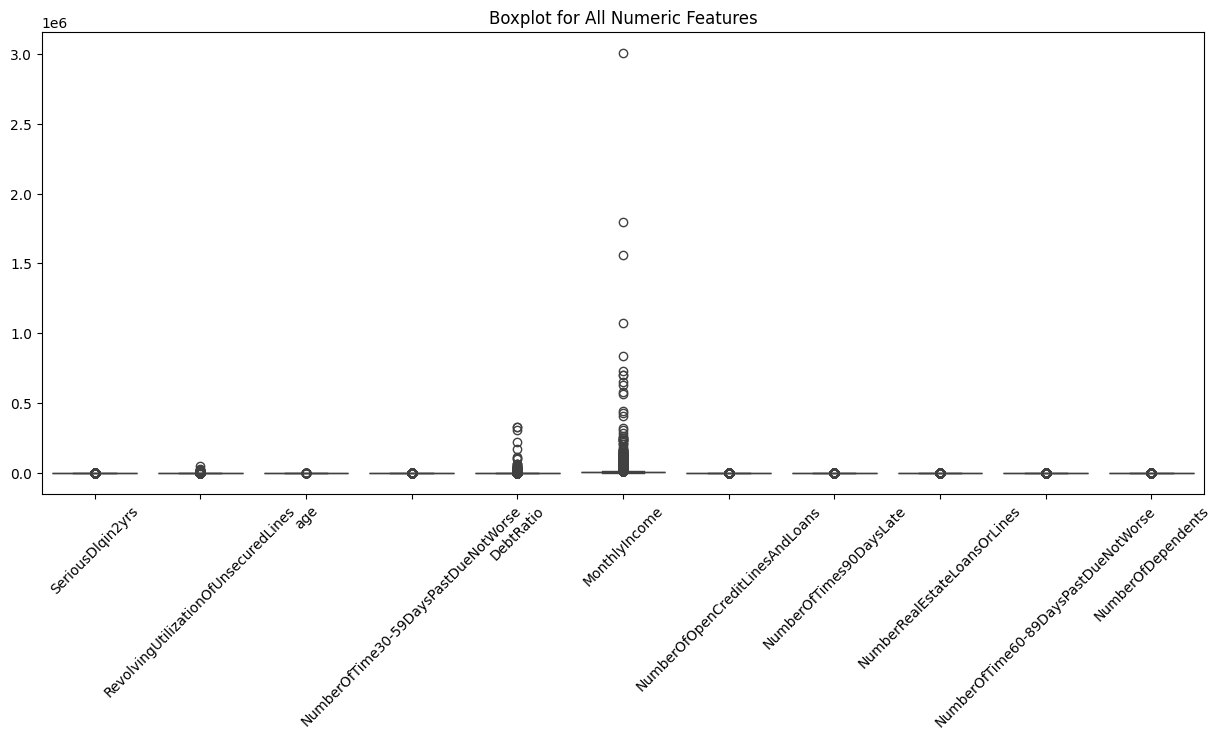

Dropped: 99 outlier rows


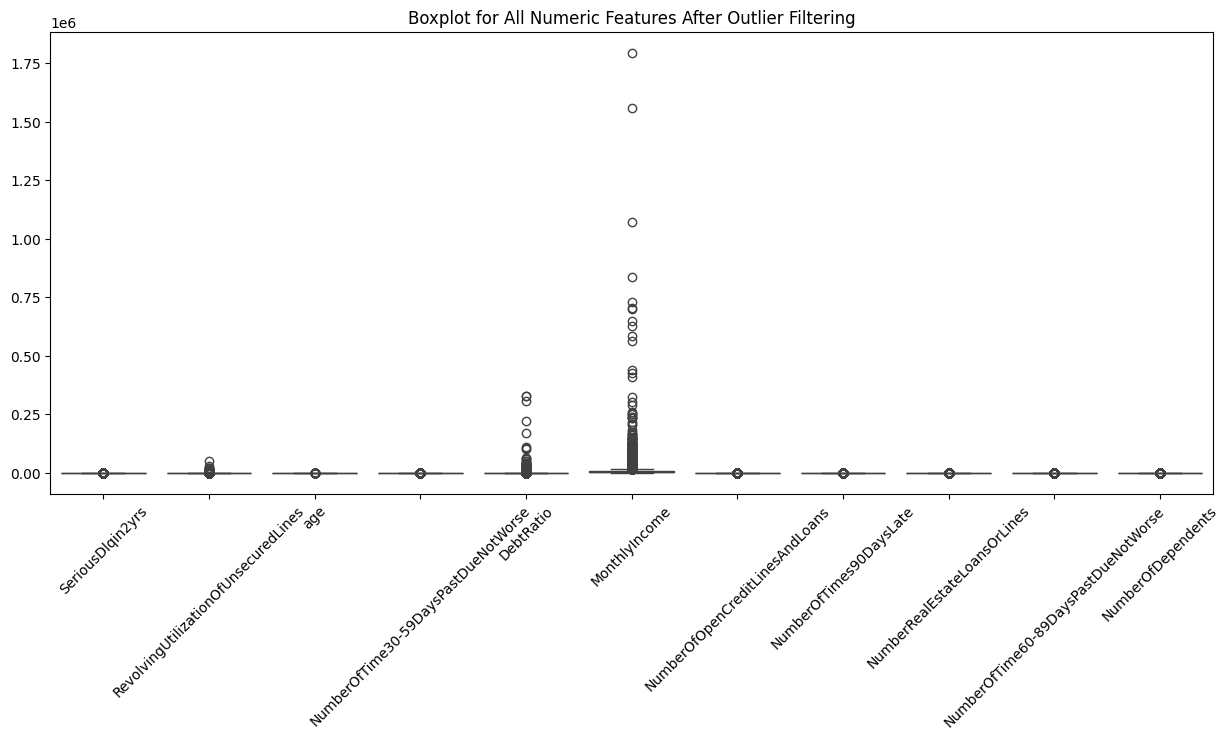

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149290.000000,149290.000000,149290.000000,149290.000000,149290.000000,1.492900e+05,149290.000000,149290.000000,149290.000000,149290.000000,149290.000000
mean,0.066796,6.074915,52.295345,0.392304,354.542964,5.351845e+03,8.482799,0.235702,1.022627,0.210778,0.740378
std,0.249669,250.348271,14.715155,3.837445,2042.462904,1.064186e+04,5.136960,3.809770,1.130096,3.794778,1.107993
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030175,41.000000,0.000000,0.177588,1.600000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154304,52.000000,0.000000,0.368275,4.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556292,63.000000,0.000000,0.875294,7.402000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [69]:
# Outlier Handling
numeric_df = df_train.select_dtypes(include=['number'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

df_train = df_train[df_train['age'] > 0].reset_index(drop=True) 

df_train = df_train.sort_values(by="MonthlyIncome", ascending=False).iloc[1:].reset_index(drop=True) 

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

df_filtered = outlier_handling(
    df_train,
    target_col="SeriousDlqin2yrs",
    threshold_high=99.975,
    threshold_low=0.035
)

numeric_df = df_filtered.select_dtypes(include=['number'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features After Outlier Filtering")
plt.xticks(rotation=45)
plt.show()

df_filtered.describe()

In [70]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_filtered)
print(target.value_counts())

Dropped cols: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139318
1      9972
Name: count, dtype: int64


In [71]:
original_cols = df_features.select_dtypes(include=['number']).columns.tolist()
print(original_cols)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [72]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [73]:
# Engineer_features
df_e = engineer_features(X_train)

Engineered: 95545 feature cols
Engineered cols: ['TotalPastDue_Squared', 'NormalizedUtilization', 'HasAnyDelinquency', 'HasMajorDelinquency', 'SevereDelinquency', 'UtilizationPerAge', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'LongTermLateFraction', '90DaysLate_Squared', 'IncomePerCreditLineHasDelinquencies', 'IncomePerCreditLine', 'DebtToIncome', 'DebtToIncomeAgeRisk', 'AgeBucket', 'DelinquencyBucket', 'UtilizationBucket', 'LatePaymentBucket', 'UtilizationBucketLateBucket']


In [74]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_e, threshold=0.25)

                                     MissingCount  MissingPercent
90DaysLate_Squared                              0            0.00
AgeBucket                                       0            0.00
DebtToIncome                                    0            0.00
DebtToIncomeAgeRisk                             0            0.00
DelinquencyBucket                               0            0.00
HasAnyDelinquency                               0            0.00
HasMajorDelinquency                             0            0.00
IncomePerCreditLine                          1100            1.15
IncomePerCreditLineHasDelinquencies          1100            1.15
LatePaymentBucket                               0            0.00
LatePaymentsPerAge                              0            0.00
LatePaymentsPerCreditLine                    1100            1.15
LongTermLateFraction                            0            0.00
NormalizedUtilization                           0            0.00
SevereDeli

In [75]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

                             UniqueCount  UniquePercent
UtilizationBucketLateBucket           31           0.03
UtilizationBucket                      6           0.01
DelinquencyBucket                      5           0.01
LatePaymentBucket                      5           0.01
AgeBucket                              3           0.00
No high cardinality cols dropped


In [76]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_high, threshold=0.05)

Column 'AgeBucket': collapsed 1 rare categories: ['Young']
Column 'DelinquencyBucket': collapsed 2 rare categories: ['Frequent', 'Chronic']
Column 'UtilizationBucket': collapsed 2 rare categories: ['Very High', 'Extreme']
Column 'LatePaymentBucket': collapsed 2 rare categories: ['FrequentLate', 'ChronicLate']
Column 'UtilizationBucketLateBucket': collapsed 27 rare categories: ['Very Low_FewLate', 'Moderate_FewLate', 'High_FewLate', 'High_ModerateLate', 'Low_FewLate', 'Moderate_ModerateLate', 'High_FrequentLate', 'Very Low_ModerateLate', 'Low_ModerateLate', 'Moderate_FrequentLate', 'High_ChronicLate', 'Very Low_FrequentLate', 'Low_FrequentLate', 'Extreme_NoLate', 'Moderate_ChronicLate', 'Very High_ModerateLate', 'Very High_FrequentLate', 'Very High_NoLate', 'Very High_FewLate', 'Low_ChronicLate', 'Very Low_ChronicLate', 'Very High_ChronicLate', 'Extreme_FewLate', 'Extreme_FrequentLate', 'Extreme_ModerateLate', 'Extreme_ChronicLate', 'nan_NoLate']


In [77]:
# Feature selection
df_selected, fs_cols_to_drop = select_features(df_collapsed, y_train, n_to_keep=14, bias_mode=None)

Using normal class weights
Kept 19 select features (including all 5 categorical)
Dropped:0 numeric select features cols
                                Feature  Importance
0                     HasAnyDelinquency  211.727951
1                     DelinquencyBucket  191.183594
2                   HasMajorDelinquency  144.116776
3             LatePaymentsPerCreditLine  118.380829
4                    LatePaymentsPerAge   77.648018
5           UtilizationBucketLateBucket   37.761223
6                  TotalPastDue_Squared   28.457769
7                    90DaysLate_Squared   21.067541
8                 NormalizedUtilization   19.479799
9                     UtilizationPerAge   16.633314
10                    LatePaymentBucket   15.264259
11                    UtilizationBucket   14.709654
12                 LongTermLateFraction    8.599997
13                    SevereDelinquency    7.570627
14                  DebtToIncomeAgeRisk    6.151903
15                         DebtToIncome    5.607

In [78]:
# Impute and scale
X_train, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_col_order, cat_col_order, cat_maps, X_train_flags = impute_and_scale(
    df_selected
)

Imputed, flagged, and scaled features


In [79]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + hc_cols_to_drop + fs_cols_to_drop

X_val = engineer_features(X_val)
X_val, X_val_flags = transform_val_test(    
    X_val,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

X_test = engineer_features(X_test)
X_test, X_test_flags = transform_val_test(
    X_test,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

Engineered: 23887 feature cols
Engineered cols: ['TotalPastDue_Squared', 'NormalizedUtilization', 'HasAnyDelinquency', 'HasMajorDelinquency', 'SevereDelinquency', 'UtilizationPerAge', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'LongTermLateFraction', '90DaysLate_Squared', 'IncomePerCreditLineHasDelinquencies', 'IncomePerCreditLine', 'DebtToIncome', 'DebtToIncomeAgeRisk', 'AgeBucket', 'DelinquencyBucket', 'UtilizationBucket', 'LatePaymentBucket', 'UtilizationBucketLateBucket']
Imputed, flagged, and scaled features
Engineered: 29858 feature cols
Engineered cols: ['TotalPastDue_Squared', 'NormalizedUtilization', 'HasAnyDelinquency', 'HasMajorDelinquency', 'SevereDelinquency', 'UtilizationPerAge', 'LatePaymentsPerAge', 'LatePaymentsPerCreditLine', 'LongTermLateFraction', '90DaysLate_Squared', 'IncomePerCreditLineHasDelinquencies', 'IncomePerCreditLine', 'DebtToIncome', 'DebtToIncomeAgeRisk', 'AgeBucket', 'DelinquencyBucket', 'UtilizationBucket', 'LatePaymentBucket', 'UtilizationBuc

In [80]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped 3096 duplicate rows. Remaining: 92449


In [81]:
# Zero importance cols 
zero_importance_cols = [
    'WasLatePaymentsPerAgeImputed',
    'WasHasAnyDelinquencyImputed',
    'WasHasMajorDelinquencyImputed',
    'WasTotalPastDue_SquaredImputed',
    'Was90DaysLate_SquaredImputed',
    'WasSevereDelinquencyImputed',
    'WasUtilizationPerAgeImputed',
    'WasNormalizedUtilizationImputed',
    'WasDebtToIncomeAgeRiskImputed',
    'WasLongTermLateFractionImputed',
    'WasDebtToIncomeImputed',
    'WasAgeBucketImputed',
    'WasDelinquencyBucketImputed',
    'WasUtilizationBucketImputed',
    'WasLatePaymentBucketImputed',
    'WasUtilizationBucketLateBucketImputed'
]

X_train = X_train.drop(columns=zero_importance_cols)
X_val   = X_val.drop(columns=zero_importance_cols)
X_test  = X_test.drop(columns=zero_importance_cols)

flags_to_keep = [f for f in X_train_flags if f not in zero_importance_cols]

X_train_flags = flags_to_keep
X_val_flags   = flags_to_keep
X_test_flags  = flags_to_keep

In [82]:
#summary
dataset_summary(X_train, y_train)

Dataset shape: (92449, 22)
Total rows: 92449
Total duplicate rows: 0


,dtype,non_null,missing,missing_%,unique,mean,std,min,25%,50%,75%,max,skew,corr_with_target,high_corr_flag,high_corr_with
HasAnyDelinquency,float64,92449,0,0.0,2,0.207422,0.405463,0.000000,0.000000,0.000000,0.000000,1.000000,1.443209,-0.002959,True,LatePaymentBucket (-0.75)
HasMajorDelinquency,float64,92449,0,0.0,2,0.088049,0.283367,0.000000,0.000000,0.000000,0.000000,1.000000,2.907610,-0.002540,True,LongTermLateFraction (0.72)
LatePaymentsPerCreditLine,float64,92449,0,0.0,209,0.077097,0.287005,0.000000,0.000000,0.000000,0.000000,11.000000,9.062749,-0.005129,False,
LatePaymentsPerAge,float64,92449,0,0.0,494,0.014380,0.215415,0.000000,0.000000,0.000000,0.000000,13.363636,42.166900,-0.004822,True,"90DaysLate_Squared (0.95), TotalPastDue_Squared (0.95)"
TotalPastDue_Squared,float64,92449,0,0.0,22,62.018983,2285.518632,0.000000,0.000000,0.000000,0.000000,86436.000000,37.678718,-0.004127,True,"90DaysLate_Squared (1.00), LatePaymentsPerAge (0.95)"
90DaysLate_Squared,float64,92449,0,0.0,18,6.976041,253.958519,0.000000,0.000000,0.000000,0.000000,9604.000000,37.672420,-0.004179,True,"TotalPastDue_Squared (1.00), LatePaymentsPerAge (0.95)"
NormalizedUtilization,float64,92449,0,0.0,81029,0.004346,0.982391,-1.426779,-0.813644,-0.123063,0.827732,9.880271,1.032571,0.002931,True,"UtilizationPerAge (0.80), UtilizationBucket (-0.77)"
UtilizationPerAge,float64,92449,0,0.0,82389,0.335326,1.060110,-0.326706,-0.261649,0.002718,0.710924,36.426678,11.680008,0.000937,True,NormalizedUtilization (0.80)
LongTermLateFraction,float64,92449,0,0.0,68,0.023036,0.103301,0.000000,0.000000,0.000000,0.000000,0.944444,4.805986,-0.004845,True,HasMajorDelinquency (0.72)
SevereDelinquency,float64,92449,0,0.0,2,0.017891,0.132556,0.000000,0.000000,0.000000,0.000000,1.000000,7.274210,-0.003416,False,


In [83]:
# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

for col in cat_col_order:
    X_train[col] = X_train[col].astype(str).map(cat_maps[col]).astype(int)
    X_val[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)
    X_test[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)

In [84]:
# Cast to float32 and int64
X_train_num = X_train[num_col_order + X_train_flags].astype('float32').values
X_val_num   = X_val[num_col_order + X_val_flags].astype('float32').values
X_test_num  = X_test[num_col_order + X_test_flags].astype('float32').values

X_train_cat = X_train[cat_col_order].astype('int64').values
X_val_cat   = X_val[cat_col_order].astype('int64').values
X_test_cat  = X_test[cat_col_order].astype('int64').values

In [85]:
# Convert to tensors
X_train_num_tensor = torch.tensor(X_train_num)
X_val_num_tensor = torch.tensor(X_val_num)
X_test_num_tensor = torch.tensor(X_test_num)

X_train_cat_tensor = torch.tensor(X_train_cat)
X_val_cat_tensor = torch.tensor(X_val_cat)
X_test_cat_tensor = torch.tensor(X_test_cat)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights, strict=True))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)

print("Numeric input shape:", X_train_num_tensor.shape)
print("Categorical input shape:", X_train_cat_tensor.shape)
print("Class weights:", class_weight_dict)

Numeric input shape: torch.Size([92449, 17])
Categorical input shape: torch.Size([92449, 5])
Class weights: {np.int64(0): np.float64(0.5357002132393844), np.int64(1): np.float64(7.502759292322675)}


In [86]:
# Datasets
class TabularDataset(Dataset):
    def __init__(self, x_num, x_cat, y):
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_num[idx], self.x_cat[idx], self.y[idx]

train_ds = TabularDataset(X_train_num_tensor, X_train_cat_tensor, y_train_tensor)
val_ds = TabularDataset(X_val_num_tensor, X_val_cat_tensor, y_val_tensor)
test_ds = TabularDataset(X_test_num_tensor, X_test_cat_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 92449, Val: 23887, Test: 29858


In [87]:
# Model
class NN(nn.Module):
    def __init__(self, num_numeric, cat_dims, emb_dims):
        super().__init__()

        self.emb_layers = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim)
            for cat_dim, emb_dim in zip(cat_dims, emb_dims, strict=True)
        ])
        self.emb_dropout = nn.Dropout(0.3)

        self.bn_num = nn.BatchNorm1d(num_numeric)

        total_emb_dim = sum(emb_dims)
        self.input_dim = num_numeric + total_emb_dim

        self.main = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.skip_proj_main = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.Dropout(0.3)
        )

        self.cat_skip = nn.Sequential(
            nn.Linear(total_emb_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, x_num, x_cat):
    
        x_cat_emb = torch.cat([
            emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)
        ], dim=1)
        x_cat_emb = self.emb_dropout(x_cat_emb)

        x_num = self.bn_num(x_num)

        x = torch.cat([x_num, x_cat_emb], dim=1)

        x_main = self.main(x)

        x_skip = self.skip_proj_main(x) + self.cat_skip(x_cat_emb)

        x_combined = x_main + x_skip
        
        return self.out(x_combined).squeeze(1)

cat_dims = [len(cat_maps[col]) for col in cat_col_order]
emb_dims = [min(50, (cat_dim + 1) // 2) for cat_dim in cat_dims]

model = NN(X_train_num.shape[1], cat_dims, emb_dims).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (emb_layers): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(4, 2)
    (2): Embedding(5, 3)
    (3): Embedding(4, 2)
    (4): Embedding(5, 3)
  )
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (bn_num): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Linear(in_features=29, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (skip_proj_main): Sequential(
    (0): Linear(in_fea

In [88]:
# Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction='none',
            pos_weight=torch.tensor(self.pos_weight, device=logits.device)
            if self.pos_weight else None
        )
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = FocalLoss(alpha=alpha, gamma=3)

In [89]:
# Train
overall_best_val_auc = 0.0
overall_best_model_state = None

for run in range(num_runs):
    print(f"\n=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_num, x_cat, yb in train_loader:
            x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_num, x_cat)  
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_num.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_num, x_cat, yb in val_loader:
                x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
                logits = model(x_num, x_cat)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_num.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | "
              f"Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)

model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")


=== Run 1/3 ===
Epoch 1/75 | Train loss: 0.028254 | Train AUC: 0.8127 | Val loss: 0.025540 | Val AUC: 0.8499
Epoch 2/75 | Train loss: 0.025093 | Train AUC: 0.8442 | Val loss: 0.025923 | Val AUC: 0.8506
Epoch 3/75 | Train loss: 0.024929 | Train AUC: 0.8466 | Val loss: 0.026592 | Val AUC: 0.8473
Epoch 4/75 | Train loss: 0.024712 | Train AUC: 0.8504 | Val loss: 0.025683 | Val AUC: 0.8518
Epoch 5/75 | Train loss: 0.024747 | Train AUC: 0.8492 | Val loss: 0.061693 | Val AUC: 0.8507
Epoch 6/75 | Train loss: 0.024672 | Train AUC: 0.8508 | Val loss: 0.025465 | Val AUC: 0.8507
Epoch 7/75 | Train loss: 0.024597 | Train AUC: 0.8521 | Val loss: 0.025738 | Val AUC: 0.8497
Epoch 8/75 | Train loss: 0.024610 | Train AUC: 0.8514 | Val loss: 0.025894 | Val AUC: 0.8520
Epoch 9/75 | Train loss: 0.024573 | Train AUC: 0.8525 | Val loss: 0.027517 | Val AUC: 0.8525
Epoch 10/75 | Train loss: 0.024526 | Train AUC: 0.8531 | Val loss: 0.025677 | Val AUC: 0.8533
Epoch 11/75 | Train loss: 0.024563 | Train AUC: 0.85

Best threshold for F1: 0.3375013
              precision    recall  f1-score   support

      Repaid       0.98      0.85      0.91     27864
   Defaulted       0.26      0.71      0.38      1994

    accuracy                           0.84     29858
   macro avg       0.62      0.78      0.64     29858
weighted avg       0.93      0.84      0.87     29858

Accuracy: 84.28%
ROC AUC: 0.862
TP=1420, FP=4120, TN=23744, FN=574
Accuracy for class 'Repaid': 85.21%
Accuracy for class 'Defaulted': 71.21%


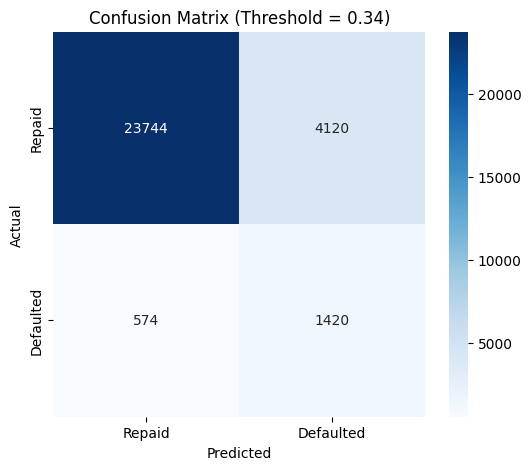

In [90]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_num, x_cat, _ in val_loader:  
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
f_beta_scores = fast_fbeta_scores(y_val, y_val_probs, thresholds, beta=2)
best_thresh_a = thresholds[np.argmax(f_beta_scores)]

y_test_probs = []
with torch.no_grad():
    for x_num, x_cat, _ in test_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh_a).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F1:", best_thresh_a)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_a:.2f})")
plt.show()

In [91]:
# Cast to float32 
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [92]:
# Model
skewed_params = {
    'scale_pos_weight': 14.0,  
    'min_child_weight': 1,     
    'max_depth': 6,           
    'subsample': 0.7,        
    'reg_alpha': 0.1,        
    'reg_lambda': 1.5,         
    'learning_rate': 0.01,
    'gamma': 0,
    'colsample_bytree': 0.6
}

model_b = xgb.XGBClassifier(
    **skewed_params,
    objective="binary:logistic",
    eval_metric=["auc"],
    n_estimators=1500,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    early_stopping_rounds=100,
    callbacks=[
        xgb.callback.LearningRateScheduler(
            lambda epoch: skewed_params["learning_rate"] * (0.99 ** epoch)
        )
    ]
)

In [93]:
# Train
model_b.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-auc:0.84490
[1]	validation_0-auc:0.85094
[2]	validation_0-auc:0.85140
[3]	validation_0-auc:0.85185
[4]	validation_0-auc:0.85277
[5]	validation_0-auc:0.85368
[6]	validation_0-auc:0.85408
[7]	validation_0-auc:0.85426
[8]	validation_0-auc:0.85465
[9]	validation_0-auc:0.85448
[10]	validation_0-auc:0.85445
[11]	validation_0-auc:0.85446
[12]	validation_0-auc:0.85433
[13]	validation_0-auc:0.85431
[14]	validation_0-auc:0.85412
[15]	validation_0-auc:0.85416
[16]	validation_0-auc:0.85434
[17]	validation_0-auc:0.85444
[18]	validation_0-auc:0.85450
[19]	validation_0-auc:0.85455
[20]	validation_0-auc:0.85454
[21]	validation_0-auc:0.85442
[22]	validation_0-auc:0.85439
[23]	validation_0-auc:0.85438
[24]	validation_0-auc:0.85431
[25]	validation_0-auc:0.85432
[26]	validation_0-auc:0.85448
[27]	validation_0-auc:0.85448
[28]	validation_0-auc:0.85454
[29]	validation_0-auc:0.85451
[30]	validation_0-auc:0.85440
[31]	validation_0-auc:0.85462
[32]	validation_0-auc:0.85460
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,[<xgboost.call...x7afd03e43290>]
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,['auc']


Best threshold for F1: 0.5194539
              precision    recall  f1-score   support

      Repaid       0.98      0.84      0.91     27864
   Defaulted       0.25      0.72      0.37      1994

    accuracy                           0.84     29858
   macro avg       0.61      0.78      0.64     29858
weighted avg       0.93      0.84      0.87     29858

Accuracy: 83.56%
ROC AUC: 0.861
TP=1442, FP=4356, TN=23508, FN=552
Accuracy for class 'Repaid': 84.37%
Accuracy for class 'Defaulted': 72.32%


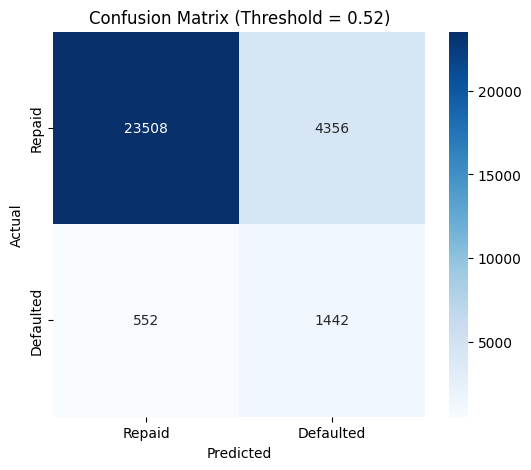

In [94]:
# Evaluation
y_probs = model_b.predict_proba(X_test)[:, 1]

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f_beta_scores = fast_fbeta_scores(y_test, y_probs, thresholds, beta=2)
best_thresh_b = thresholds[np.argmax(f_beta_scores)]

y_pred = (y_probs > best_thresh_b).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh_b)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_b:.2f})")
plt.show()

In [95]:
# Importance XGB
all_features = model_b.get_booster().feature_names
importance_dict = model_b.get_booster().get_score(importance_type="gain")
full_importance = {feat: importance_dict.get(feat, 0.0) for feat in all_features}
importance_df = (
    pd.DataFrame({
        "Feature": list(full_importance.keys()),
        "Importance": list(full_importance.values())
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)
print(importance_df)

                                          Feature   Importance
0                               HasAnyDelinquency  7890.922852
1                              LatePaymentsPerAge  1493.084961
2                            TotalPastDue_Squared  1458.450317
3                     UtilizationBucketLateBucket  1382.925293
4                               DelinquencyBucket   446.552460
5                             HasMajorDelinquency   252.459442
6                               UtilizationPerAge   225.107651
7                           NormalizedUtilization   218.198181
8                               UtilizationBucket   172.852356
9                             DebtToIncomeAgeRisk    70.733482
10                      LatePaymentsPerCreditLine    60.977272
11                                   DebtToIncome    60.048496
12                            IncomePerCreditLine    53.396763
13                              LatePaymentBucket    46.028893
14                                      AgeBucket    43

In [96]:
# Importance NN
model_cpu = copy.deepcopy(model).cpu()

def shap_cpu(X):
    X_num = X[:, :X_train_num_tensor.shape[1]]
    X_cat = X[:, X_train_num_tensor.shape[1]:].astype(int)
    
    X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
    X_cat_tensor = torch.tensor(X_cat, dtype=torch.long)
    
    model_cpu.eval()
    with torch.no_grad():
        logits = model_cpu(X_num_tensor, X_cat_tensor)
        probs = torch.sigmoid(logits).numpy()
    return probs

X_train_combined = np.hstack([X_train_num_tensor.numpy(), X_train_cat_tensor.numpy()])
X_val_combined = np.hstack([X_val_num_tensor.numpy(), X_val_cat_tensor.numpy()])
background_full = X_train_combined  
background = shap.sample(background_full, 100)
explainer = shap.KernelExplainer(shap_cpu, background)
X_val_sample = X_val_combined[:500]
shap_values = explainer.shap_values(X_val_sample)
feature_names = list(num_col_order) + list(cat_col_order) + list(X_train_flags)

shap_values_array = np.array(shap_values)  
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
shap_importance = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
})

shap_importance = shap_importance.sort_values(by="mean_abs_shap", ascending=False)
print(shap_importance)

  0%|          | 0/500 [00:00<?, ?it/s]

                                          feature  mean_abs_shap
0                               HasAnyDelinquency       0.019013
6                           NormalizedUtilization       0.015425
7                               UtilizationPerAge       0.014167
10                            DebtToIncomeAgeRisk       0.008823
21                  WasIncomePerCreditLineImputed       0.006867
13                            IncomePerCreditLine       0.005469
1                             HasMajorDelinquency       0.005242
17                              LatePaymentBucket       0.004341
19            WasLatePaymentsPerCreditLineImputed       0.003816
11                                   DebtToIncome       0.002807
18                    UtilizationBucketLateBucket       0.002285
2                       LatePaymentsPerCreditLine       0.002220
8                            LongTermLateFraction       0.001104
9                               SevereDelinquency       0.001103
20  WasIncomePerCreditLin

In [97]:
# Save NN model
torch.save(model.state_dict(), "cr_weights.pth")

In [98]:
# Save xgb model
model_b.save_model("cr_b.json")

In [99]:
# Save for hosting
joblib.dump(best_thresh_a, "threshold_a.pkl")
joblib.dump(best_thresh_b, "threshold_b.pkl")
joblib.dump(num_imputer, "num_imputer.pkl")
joblib.dump(cat_imputer, "cat_imputer.pkl")
joblib.dump(robust_scaler, "robust_scaler.pkl")
joblib.dump(std_scaler, "std_scaler.pkl")
joblib.dump(num_col_order, "num_col_order.pkl")
joblib.dump(cat_maps, "cat_maps.pkl")
joblib.dump(cat_col_order, "cat_col_order.pkl")
joblib.dump(X_train_flags, "X_train_flags.pkl")
joblib.dump(skewed_col_order, "skewed_col_order.pkl")
joblib.dump(rare_maps, "rare_maps.pkl")

['rare_maps.pkl']

#### 